In [1]:
import os
import sys
from vit_pytorch import ViT
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import numpy as np
from tqdm import tqdm
import cv2
import wandb

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from cancer_classifier.config import MODELS_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR, INTERIM_DATA_DIR, EXTERNAL_DATA_DIR, CLASSES
from cancer_classifier.processing.image_utils import adjust_image_contrast, resize_image_tensor, normalize_image_tensor, augment_image_tensor, process_dataset, save_processed_images, crop_image
from cancer_classifier.processing.dataset_loader import BrainTumorDataset, preprocess_images, unnormalize

%load_ext autoreload
%autoreload 2

2025-05-18 15:37:32.911 | INFO     | cancer_classifier.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/deep-learning-cancer-classifier


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preprocessing

In [4]:
img_size = (256, 256)
clip_limit = 2.0
tile_size = (1,1)

### data crop and contract equilazing

In [5]:
img_size = (256, 256)
clip_limit = 2.0
tile_size = (1,1)

# preprocess_images(src_dir=RAW_DATA_DIR, dist_dir=PROCESSED_DATA_DIR,img_size=img_size, clip_limit=clip_limit, tile_size=tile_size)

### data augmentation

In [6]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize(size=img_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    # torchvision.transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),  #as images are cropped out from surounding black space  to contains only ROI 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

Dataset = BrainTumorDataset(
    root_dir=PROCESSED_DATA_DIR,
    transform=transformers
)

print(Dataset.class_to_idx)

{'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


### data spliting 

In [7]:
batch_nbr = 16
train_ratio = 0.80
test_ratio = 0.10
val_ratio = 0.10

train_loader, val_loader, test_loader = Dataset.get_dataloaders(
    batch_size=batch_nbr,
    train_ratio=train_ratio,
    val_ratio=val_ratio
)

# Model Architecture: Vision Transformer (Dosovitskiy et al., 2021)

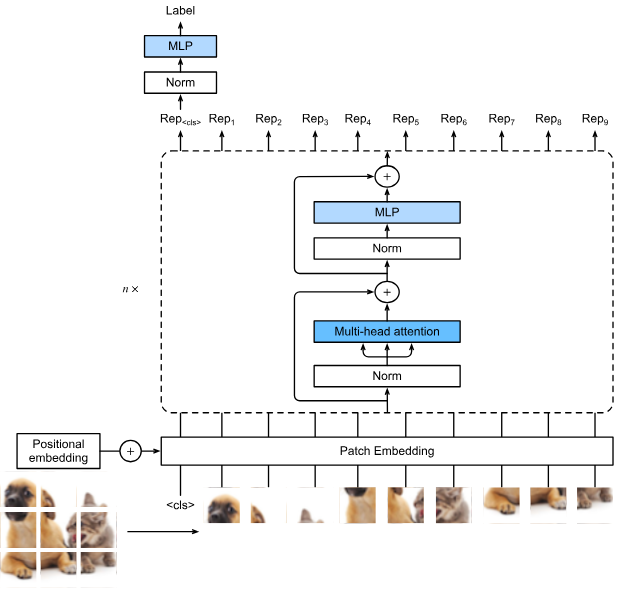

In [8]:
patch_size = 16
num_hiddens = 516
num_heads = 8     # for simplicity, 𝑝𝑞 = 𝑝𝑘 = 𝑝𝑣 = num_hiddens/num_heads
mlp_num_hiddens = 156
num_blks = 3
emb_dropout, blk_dropout = 0.0001, 0.0001

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=256, patch_size=32, num_hiddens=516):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        # for each image int the batch we have for each patch pixel its value after convolution for each output channel
        return self.conv(X).flatten(2).transpose(1, 2)

In [10]:
# # patch_size = 16
# num_hiddens, num_heads = 516, 8     # for simplicity, 𝑝𝑞 = 𝑝𝑘 = 𝑝𝑣 = num_hiddens/num_heads 
# mlp_num_hiddens = 156
# num_blks = 8            # is n in the ilustration image
# img_size = (32, 32)
# batch_size = 8
# patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
# X = torch.zeros(batch_size, 3, img_size[0], img_size[1])


# expected_shape = (batch_size, (img_size[0] // patch_size) * (img_size[1] // patch_size), num_hiddens)
# (patch_emb(X).shape, expected_shape)

In [11]:
def transpose_qkv(self, X):   # not used
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(self, X): # not used
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

class PositionalEncoding(nn.Module): # not used
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)/ torch.pow(10000, torch.arange(
        0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

class AddNorm(nn.Module): # not used
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)
    
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / np.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
   
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))
        
     
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        
        # Create separate sets of projection layers for each head
        self.W_q = nn.ModuleList([nn.LazyLinear(num_hiddens // num_heads + (num_hiddens % num_heads if i == num_heads - 1 else 0), bias=bias) for i in range(num_heads)])
        self.W_k = nn.ModuleList([nn.LazyLinear(num_hiddens // num_heads + (num_hiddens % num_heads if i == num_heads - 1 else 0), bias=bias) for i in range(num_heads)])
        self.W_v = nn.ModuleList([nn.LazyLinear(num_hiddens // num_heads + (num_hiddens % num_heads if i == num_heads - 1 else 0), bias=bias) for i in range(num_heads)])
        
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)  # Final output projection

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        batch_size = queries.shape[0]
        
        # Compute queries, keys, and values for each head separately
        queries = torch.cat([self.W_q[i](queries) for i in range(self.num_heads)], dim=-1)
        keys = torch.cat([self.W_k[i](keys) for i in range(self.num_heads)], dim=-1)
        values = torch.cat([self.W_v[i](values) for i in range(self.num_heads)], dim=-1)
        
        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries, num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        # output_concat = output.T
        output_concat = output.reshape(batch_size, -1, self.num_heads * (num_hiddens // num_heads) + num_hiddens % num_heads)
        return self.W_o(output_concat)
        


In [12]:

attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 256, 6
# valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
(attention(X, X, X, None).shape, (batch_size, num_queries, num_hiddens))

(torch.Size([2, 256, 516]), (2, 256, 516))

In [13]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.mh_attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.mh_attention(*([self.ln1(X)] * 3), valid_lens) #residual layer
        return X + self.mlp(self.ln2(X))

In [14]:
class ViTModel(nn.Module):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()

        # self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens)) # like a single pixel with num_hiddens channels
        self.num_vtokens = self.patch_embedding.num_patches + 1  # Add the cls token

        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_vtokens, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()

        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(num_hiddens, num_hiddens, mlp_num_hiddens,
                                                  num_heads, blk_dropout, use_bias))
        
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens * self.num_vtokens),
                                  nn.Linear(num_hiddens * self.num_vtokens, num_hiddens),
                                  nn.Linear(num_hiddens, num_classes)
                                  )
        
        # self.heads_agg = nn.ModuleList([nn.Sequential(nn.LayerNorm(num_hiddens), nn.Linear(num_hiddens, CLASSES)) for _ in range(self.num_vtokens)])

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        # we will instead pass over all the patches and the cls token
        X = X.flatten(1,2)
        
        # X = torch.cat([head(x) for head, x in zip(self.heads_agg, X)], dim=1)
        
        return self.head(X)

In [15]:
Vit_model = ViTModel(img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=len(CLASSES)).to(device)

## Training the model

### defining Loss function, Optimization method, and training parameters

In [16]:
loss_fn = nn.CrossEntropyLoss()
weights_decay = 0.0001
learning_rate = 0.0001
epochs = 40

# optimizer = torch.optim.Adam(
#     Vit_model.parameters(),
#     lr=learning_rate,
#     weight_decay=weights_decay
# ) #->70%

optimizer = torch.optim.AdamW(
    Vit_model.parameters(),
    lr=learning_rate,
    weight_decay=weights_decay
) #->77.4

# optimizer = torch.optim.SGD(
#     Vit_model.parameters(),
#     lr=learning_rate,
#     weight_decay=weights_decay
# ) #-> 77.5

In [17]:
def test_loop(dataloader, model, loss_fn, epoch=0):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    true_labels = []
    pred_labels = []
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(pred.argmax(1).cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
#     wandb.log({"epoch": epoch,"accuracy": f"{(100*correct):>0.1f}", "test_loss": test_loss})


    
    
    return true_labels, pred_labels, correct, test_loss


In [18]:
from cancer_classifier.modeling.train import train
# import evaluate from cancer_classifier.modeling.evaluate as evaluate
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device) 
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_nbr + len(X)
#             wandb.log({"step":  f"{current:>5d}/{size:>5d}", "train_loss": loss})
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            

for epoch in tqdm(range(epochs)):
    print("----------------- EPOCH " + str(epoch) + "------------------")
    train_loop(
        dataloader=train_loader,
        model=Vit_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        epoch=epoch
        )
    true_labels, pred_labels, correct, val_loss =  test_loop(
        dataloader=val_loader,
        model=Vit_model,
        loss_fn=loss_fn,
        epoch=epoch
    )

  0%|          | 0/40 [00:00<?, ?it/s]

----------------- EPOCH 0------------------
loss: 1.111997  [   16/ 4845]
loss: 2.002525  [ 1616/ 4845]
loss: 1.239960  [ 3216/ 4845]
loss: 12.325743  [ 4816/ 4845]


  2%|▎         | 1/40 [00:23<15:24, 23.69s/it]

Test Error: 
 Accuracy: 56.1%, Avg loss: 9.645741 

----------------- EPOCH 1------------------
loss: 4.584329  [   16/ 4845]
loss: 0.282759  [ 1616/ 4845]
loss: 1.508842  [ 3216/ 4845]
loss: 2.030628  [ 4816/ 4845]


  5%|▌         | 2/40 [00:42<13:00, 20.55s/it]

Test Error: 
 Accuracy: 67.2%, Avg loss: 2.232102 

----------------- EPOCH 2------------------
loss: 0.771660  [   16/ 4845]
loss: 1.506823  [ 1616/ 4845]
loss: 0.608036  [ 3216/ 4845]
loss: 1.006466  [ 4816/ 4845]


  8%|▊         | 3/40 [00:59<11:49, 19.16s/it]

Test Error: 
 Accuracy: 78.7%, Avg loss: 0.894203 

----------------- EPOCH 3------------------
loss: 0.712015  [   16/ 4845]
loss: 2.949960  [ 1616/ 4845]
loss: 0.824818  [ 3216/ 4845]
loss: 0.566150  [ 4816/ 4845]


 10%|█         | 4/40 [01:17<11:19, 18.87s/it]

Test Error: 
 Accuracy: 80.7%, Avg loss: 0.638819 

----------------- EPOCH 4------------------
loss: 0.643002  [   16/ 4845]
loss: 0.904450  [ 1616/ 4845]
loss: 1.125504  [ 3216/ 4845]
loss: 0.768797  [ 4816/ 4845]


 12%|█▎        | 5/40 [01:35<10:42, 18.35s/it]

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.600198 

----------------- EPOCH 5------------------
loss: 0.282073  [   16/ 4845]
loss: 0.354846  [ 1616/ 4845]
loss: 0.326537  [ 3216/ 4845]
loss: 0.574021  [ 4816/ 4845]


 15%|█▌        | 6/40 [01:52<10:12, 18.03s/it]

Test Error: 
 Accuracy: 78.7%, Avg loss: 0.580223 

----------------- EPOCH 6------------------
loss: 0.865964  [   16/ 4845]
loss: 0.335879  [ 1616/ 4845]
loss: 1.110469  [ 3216/ 4845]
loss: 0.408127  [ 4816/ 4845]


 18%|█▊        | 7/40 [02:10<09:49, 17.85s/it]

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.535697 

----------------- EPOCH 7------------------
loss: 0.403998  [   16/ 4845]
loss: 0.578315  [ 1616/ 4845]
loss: 1.493078  [ 3216/ 4845]
loss: 0.145614  [ 4816/ 4845]


 20%|██        | 8/40 [02:28<09:38, 18.08s/it]

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.471779 

----------------- EPOCH 8------------------
loss: 0.689564  [   16/ 4845]
loss: 0.443257  [ 1616/ 4845]
loss: 0.734425  [ 3216/ 4845]
loss: 0.166411  [ 4816/ 4845]


 22%|██▎       | 9/40 [02:46<09:13, 17.86s/it]

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.384349 

----------------- EPOCH 9------------------
loss: 0.159764  [   16/ 4845]
loss: 0.353474  [ 1616/ 4845]
loss: 0.302559  [ 3216/ 4845]
loss: 0.612849  [ 4816/ 4845]


 25%|██▌       | 10/40 [03:03<08:51, 17.72s/it]

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.336182 

----------------- EPOCH 10------------------
loss: 0.440988  [   16/ 4845]
loss: 0.138072  [ 1616/ 4845]
loss: 0.190735  [ 3216/ 4845]
loss: 0.147696  [ 4816/ 4845]


 28%|██▊       | 11/40 [03:22<08:39, 17.93s/it]

Test Error: 
 Accuracy: 86.8%, Avg loss: 0.330771 

----------------- EPOCH 11------------------
loss: 0.253891  [   16/ 4845]
loss: 0.163873  [ 1616/ 4845]
loss: 0.464083  [ 3216/ 4845]
loss: 0.529389  [ 4816/ 4845]


 30%|███       | 12/40 [03:39<08:17, 17.78s/it]

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.397643 

----------------- EPOCH 12------------------
loss: 0.811972  [   16/ 4845]
loss: 0.425272  [ 1616/ 4845]
loss: 0.121641  [ 3216/ 4845]
loss: 0.346191  [ 4816/ 4845]


 32%|███▎      | 13/40 [03:57<07:58, 17.73s/it]

Test Error: 
 Accuracy: 87.6%, Avg loss: 0.322578 

----------------- EPOCH 13------------------
loss: 0.378503  [   16/ 4845]
loss: 0.228838  [ 1616/ 4845]
loss: 0.267834  [ 3216/ 4845]
loss: 0.197614  [ 4816/ 4845]


 35%|███▌      | 14/40 [04:14<07:39, 17.66s/it]

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.354930 

----------------- EPOCH 14------------------
loss: 0.382093  [   16/ 4845]
loss: 0.491529  [ 1616/ 4845]
loss: 0.360060  [ 3216/ 4845]
loss: 0.850164  [ 4816/ 4845]


 38%|███▊      | 15/40 [04:33<07:27, 17.91s/it]

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.314007 

----------------- EPOCH 15------------------
loss: 0.134731  [   16/ 4845]
loss: 0.246100  [ 1616/ 4845]
loss: 0.301235  [ 3216/ 4845]
loss: 0.761523  [ 4816/ 4845]


 40%|████      | 16/40 [04:50<07:06, 17.76s/it]

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.273382 

----------------- EPOCH 16------------------
loss: 0.517260  [   16/ 4845]
loss: 0.371115  [ 1616/ 4845]
loss: 0.280891  [ 3216/ 4845]
loss: 0.400306  [ 4816/ 4845]


 42%|████▎     | 17/40 [05:07<06:45, 17.64s/it]

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.300570 

----------------- EPOCH 17------------------
loss: 0.232060  [   16/ 4845]
loss: 0.846267  [ 1616/ 4845]
loss: 0.227425  [ 3216/ 4845]
loss: 0.583194  [ 4816/ 4845]


 45%|████▌     | 18/40 [05:25<06:29, 17.71s/it]

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.266729 

----------------- EPOCH 18------------------
loss: 0.167256  [   16/ 4845]
loss: 0.491856  [ 1616/ 4845]
loss: 0.339865  [ 3216/ 4845]
loss: 0.433726  [ 4816/ 4845]


 48%|████▊     | 19/40 [05:43<06:14, 17.84s/it]

Test Error: 
 Accuracy: 89.8%, Avg loss: 0.271361 

----------------- EPOCH 19------------------
loss: 0.188408  [   16/ 4845]
loss: 0.145617  [ 1616/ 4845]
loss: 0.657508  [ 3216/ 4845]
loss: 0.432947  [ 4816/ 4845]


 50%|█████     | 20/40 [06:01<05:54, 17.71s/it]

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.227765 

----------------- EPOCH 20------------------
loss: 0.298817  [   16/ 4845]


 50%|█████     | 20/40 [06:03<06:03, 18.16s/it]


KeyboardInterrupt: 

In [19]:
true_labels, pred_labels, correct, test_loss =  test_loop(
    dataloader=test_loader,
    model=Vit_model,
    loss_fn=loss_fn
)
# train(
#     model=Vit_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     test_loader=test_loader,
#     loss_fn=loss_fn,
#     optimizer=optimizer,
#     epochs=epochs,
#     device=device
# )

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.253995 



## Evaluating the model

### Covariance Matrix

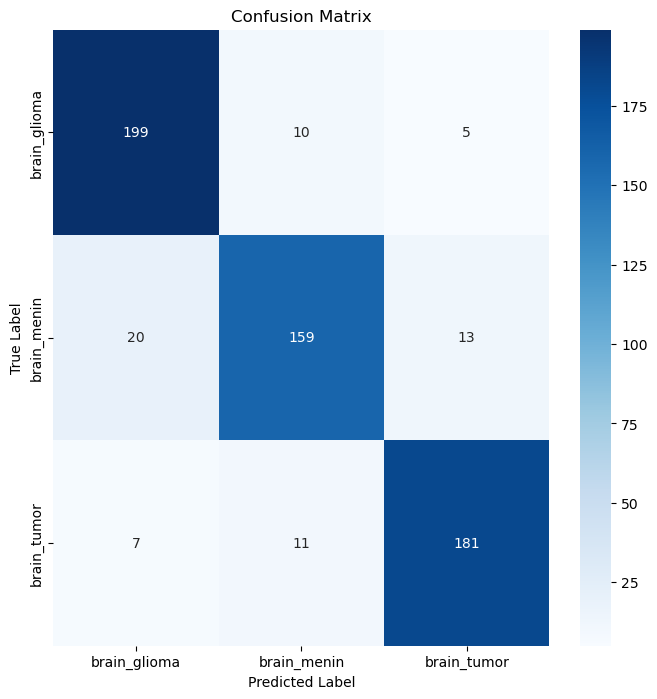

In [26]:
from cancer_classifier.plots import visualize_sample_images,  plot_confusion_matrix
import time

# visualize_sample_images(
#     dataset=Dataset,
# )
plot_confusion_matrix(
    true_classes=true_labels,
    predicted_classes=pred_labels,
    model_name =  time.strftime("%Y-%m-%d_%H-%M-%S") + "_Vit_model_FC-per-head_MLP_Reps_NOSIMOD" + f"{(100*correct):>0.1f}%"
)

### serializing the model

In [27]:
import time
model_name = f"{(100*correct):>0.1f}%--" + time.strftime("%Y-%m-%d_%H-%M-%S") + "_Vit_edited_model_FC-per-head_MLP_Reps_cropped_img_NOSIMOD.pth"
torch.save(Vit_model.state_dict(), MODELS_DIR / model_name)
print("Saved PyTorch Model State to " +  model_name)

Saved PyTorch Model State to 89.1%--2025-05-18_15-46-05_Vit_edited_model_FC-per-head_MLP_Reps_cropped_img_NOSIMOD.pth


## References

- https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html
- https://github.com/lucidrains/vit-pytorch
- https://docs.pytorch.org/tutorials/beginner/basics/transforms_tutorial.html
